# RL Notebook

In [11]:
# pip install pygame
# pip install gym==0.26.2
# pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests # compatible with gym 0.24+
# pip install numpy --pre torch --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [72]:
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')
os.getcwd()

from src.images.dataloader import CadastralImage

import gym
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box
import random
import math 

import pygame
# import stable_baselines3
# from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

from PIL import Image
import torch
from torchvision import transforms

# listing img files in directory data
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# File directory
src = "./data/cadastral/"
onlyfiles = [f for f in listdir(src) if isfile(join(src, f))]
filesrc = src + random.choice(onlyfiles)
# print(f"files in the folder: {len(onlyfiles)}")

# Params
obsRes = 64
memorySlots = 5
obsRadius = 25
channels = 3
resolution = (int(1280 / 4), int(1280 / 4)) # image resolution
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
label = 1 # true label

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [142]:
imholder = CadastralImage(filesrc, resolution=(600, 600), device=device)

In [143]:
imholder.src

'./data/cadastral/CadastralX2670494Y1262645S250.png'

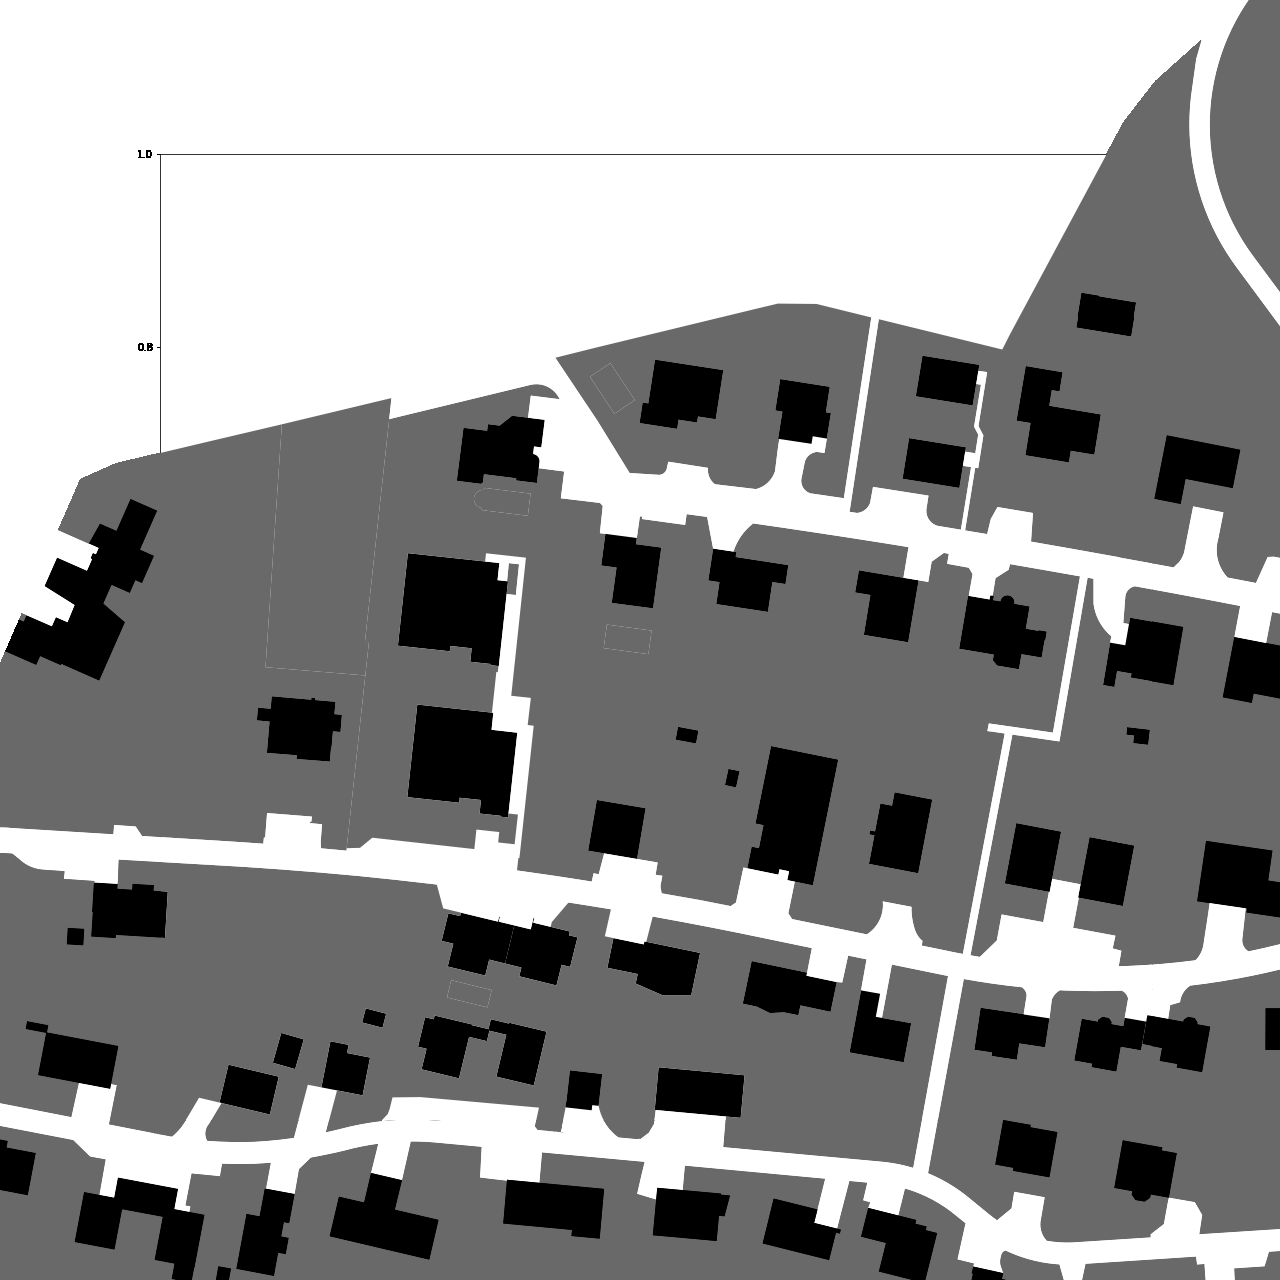

In [144]:
imholder.image

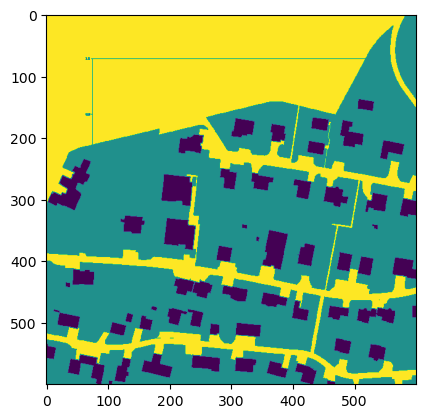

In [146]:
imholder.show_image()

# 1. Load Synthetic Cities Pics

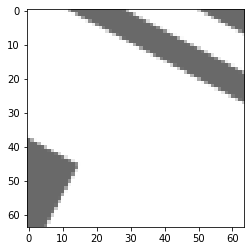

In [58]:
# filesrc = random.choice(onlyfiles)
image = Image.open(filesrc)
x = TF.to_tensor(image)
# too large, let's take a cut
lim = 64
xSmall = torch.split(x[:3], lim, dim=1)[0].split(lim, dim=2)[0] # 4th channel is transparency
plt.imshow(xSmall.permute(*torch.arange(xSmall.ndim - 1, -1, -1)));

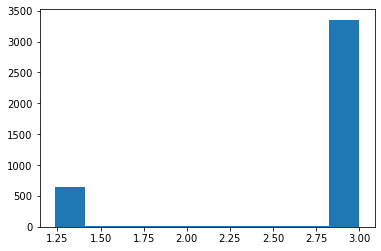

In [59]:
intensity = xSmall.sum(axis=0) 
plt.hist(intensity.flatten(start_dim=0).tolist());

In [60]:
def toRLScore(x):
    score = int
    if x < 0.5:
        # black -> building
        score = 10
    elif x > 2.5:
        # white -> road
        score = -1
    else:
        # neither building nor road
        score = -10
    return score

In [61]:
vfunc = np.vectorize(toRLScore)

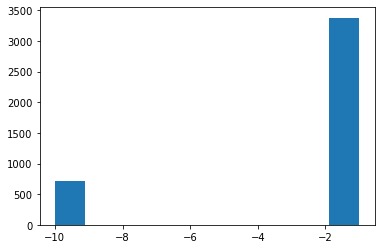

In [62]:
RLScore = vfunc(intensity)
plt.hist(RLScore.flatten());

All nicely packed in a function

In [63]:
def imgToScore(src, res):
    image = Image.open(src)
    x = TF.to_tensor(image)
    # top left corner, could be any place within the raster 
    xSmall = x[:3].split(res, dim=1)[0].split(res, dim=2)[0]
    xSmall= xSmall.permute(0,2,1) # getting x and y right
    intensity = xSmall.sum(axis=0)
    RLScore = vfunc(intensity)
    return xSmall, RLScore

testing

file extracted: ../data/cadastralExport/CadastralX2679494Y1249145S250.png


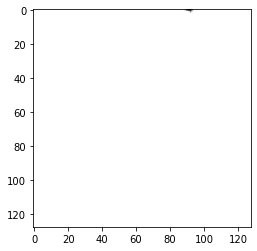

In [64]:
filesrc = src+random.choice(onlyfiles)
print(f"file extracted: {filesrc}")
imgSample, ScoreSample = imgToScore(filesrc, 128)
plt.imshow(imgSample.permute(2,1,0));

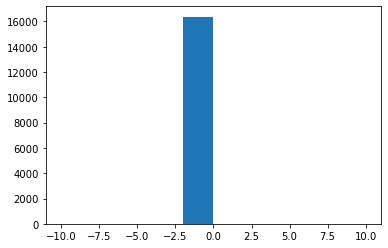

In [65]:
plt.hist(ScoreSample.flatten());

Conditions to position agent and target (if wished) everytime the environment is resetted

In [66]:
## a = np.random.randint(0, 128, size=2, dtype=int)
## t = np.random.randint(0, 128, size=2, dtype=int)
## 
## cond1 = np.array_equal(a,t)
## cond2 = ScoreSample[t[0]][t[1]] != -1 # in a road ScoreSample.flatten().max()
## cond3 = ScoreSample[a[0]][a[1]] != -1 # in a road ScoreSample.flatten().max()
## 
## while (cond1 or cond2 or cond3):
##     t = np.random.randint(0, 128, size=2, dtype=int)
##     a = np.random.randint(0, 128, size=2, dtype=int)
##     cond1 = np.array_equal(a,t)
##     cond2 = ScoreSample[t[0]][t[1]] != -1
##     cond3 = ScoreSample[a[0]][a[1]] != -1
## 
## print(f"position of the agent: X:{a[0]}, Y:{a[1]} | Reward: {ScoreSample[a[1]][a[0]]}")
## print(f"position of the target: X:{t[0]}, Y:{t[1]} | Reward: {ScoreSample[t[1]][t[0]]}")
## 
## plt.imshow(imgSample.permute(*torch.arange(imgSample.ndim - 1, -1, -1)), origin='lower')
## plt.scatter(t[0], t[1], label='target')
## plt.scatter(a[0], a[1], color='r', label = 'agent')
## plt.legend();

# 2. Real City Environment 
based on https://www.gymlibrary.dev/content/environment_creation/

In [100]:
# this class loads and clips the image according to the target resolution, where there is less homogeneity

class imgLoader():
    def __init__(self, src, resolution, device):
        self.src = src
        self.res = resolution
        self.img = Image.open(self.src)
        self.size = self.img.size
        self.reps = [int(self.size[0]/self.res), int(self.size[1]/self.res)]
        self.scores = [1, 0, -1] # black, white, grey
        self.vfunc = np.vectorize(self.toRLScore)
        self.X = TF.to_tensor(self.img)[:3].permute(1,2,0).to(device) #removing the alpha channel
        self.ResxSmall = self.X.to(device)
        self.ResRLScore = np.zeros([self.res, self.res])
        
    def loadAndCut(self):
        # cut less homogeneous corner
        worseGini = 0
        for x in range(self.reps[0]):
            # print(f"X rep: {x}")
            for y in range(self.reps[1]):
                # print(f"Y rep: {y}")
                xSmall = self.X.split(self.res, dim=0)[x].split(self.res, dim=1)[y].split(3, dim=2)[0]
                intensity = xSmall.sum(axis=2).cpu()
                # print(f"intensitz: {intensity}")
                RLScore = self.vfunc(intensity)
                flatRLScore = RLScore.flatten()
                b = np.count_nonzero(flatRLScore == self.scores[0]) / flatRLScore.size
                r = np.count_nonzero(flatRLScore == self.scores[1]) / flatRLScore.size
                g = np.count_nonzero(flatRLScore == self.scores[2]) / flatRLScore.size
                Gini = 1 - (b**2 + r**2 + g**2)
                # print(f"single gini cohefficients: {b}, {r}, {g}")
                # print(f"gini cohefficient: {Gini} - Worse cohefficient: {worseGini}")
                if Gini > worseGini:
                    worseGini = Gini
                    # print(f"Worse Gini Score: {Gini}")
                    self.ResxSmall = xSmall
                    self.ResRLScore = RLScore.T
        return
    
    def toRLScore(self, x):
        score = int
        if x < 0.5:
            # black -> building
            score = self.scores[0]
        elif x > 2.5:
            # white -> road
            score = self.scores[1]
        else:
            # neither building nor road
            score = self.scores[2]
        return score
    
    def printCut(self):
        # plt.imshow(self.ResxSmall.permute(2,1,0));
        plt.imshow(self.ResxSmall);
    
    def printEntire(self):
        plt.imshow(self.X);

In [226]:
# this class collects and consolidates all the observations
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'prediction'))

class Observation():
    def __init__(self, radius, capacity):
        self.memory = list()
        self.coords = list()
        self.transitions = deque([], maxlen = 10**10) # here the state is stored 
        self.observations = deque([], maxlen=capacity) # here the last n observations are stored
        self.recording = False
    
    def check(self, observation: np.array) -> bool:
        obs_len = observation.size
        return obs_len == radius**2 # true if not close to the boarders of the pictures
    
    def consolidate(self, observation: Transition):#np.array):
        # self.memory.extend([o for o in observation if (o[0], o[1]) not in self.coords])
        # print(f"observations: {observation}")
        self.recording=True
        for o in observation:
            # print(f"single observation : {o}")
            if ((o[0], o[1]) not in self.coords):
                self.coords.append((o[0], o[1])) 
                self.memory.append(o)
        return
    
    def push(self, *args):
        """Save a transition"""
        self.recording=True
        self.transitions.append(Transition(*args))
        return
    
    def pushObs(self, observation):
        self.recording=True
        self.observations.append(observation)
        return
        
    def getLength(self) -> int:
        return len(self.memory)
    
    def getObs(self, batch_size) -> list:
        if self.recording:
            return self.observations
    
    def getSample(self, batch_size) -> list:
        if self.recording:
            return random.sample(population=self.memory, k=batch_size)
        else:
            return None
    def getTransitionSample(self, batch_size):
        if self.recording:
            return random.sample(population=self.transitions, k=batch_size)
        else:
            return None

## 2.2 Experiments to be removed

In [179]:
o = Observation(10,10)
len(o.observation)

0

In [180]:
o.observation.capacity

AttributeError: 'Observation' object has no attribute 'observation'

In [46]:
# Experiments on the mask layer
t = torch.zeros(image.size)
t.size()
coord = [0,0]
t[coord[0], coord[1]] = 1
t

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [73]:
s = TF.to_tensor(image)[:3]
s.size()

torch.Size([3, 1280, 1280])

In [250]:
i = imgLoader(filesrc, res)
# i.X.flatten().size()
i.img.size[0]

1280

In [140]:
radius = 10
position = [random.randint(0, i.size[0]), random.randint(0, i.size[1])]
# position = [0, 0]
#i
print(position)

[785, 1227]


In [141]:
xmin, xmax = np.clip(position[0] - radius, radius, i.size[0]-radius), np.clip(position[0] + radius, radius, i.size[0]-radius) 
ymin, ymax = np.clip(position[1] - radius, radius, i.size[1]-radius), np.clip(position[1] + radius, radius, i.size[1]-radius) 
print(xmin, xmax)
print(ymin, ymax)

775 795
1217 1237


In [246]:
i.size()

AttributeError: 'int' object has no attribute 'size'

In [143]:
# i.X[xmin:xmax][ymin:ymax].size()
print(i.X[:][xmin:xmax, ymin:ymax].size())
f = i.X[:][xmin:xmax, ymin:ymax]
f

torch.Size([20, 20, 3])


tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [0.9412, 0.9412, 0.9412],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        ...,

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.

In [144]:
xmin, xmax = np.clip(position[0] - radius, radius, i.size[0]-radius), np.clip(position[0] + radius, radius, i.size[0]-radius) 
ymin, ymax = np.clip(position[1] - radius, radius, i.size[1]-radius), np.clip(position[1] + radius, radius, i.size[1]-radius) 
f = i.X[xmin:xmax, ymin:ymax]

In [104]:
i.size[0]

1280

In [154]:
t = torch.zeros(i.size)
t.size()

torch.Size([1280, 1280])

In [155]:
p = [123,187]
t[p[0],p[1]] = 1

In [156]:
t[p[0]-5:p[0]+1, p[1]-5:p[1]+5]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [94]:
RCenv.imgloader.X.size()

torch.Size([1280, 1280, 4])

In [95]:
RCenv.ObservationsToTensor()

tensor([[[1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.

## 2.3 Environment Class

In [169]:
RCenv.imgLoader.ResxSmall.size()[2]

3

In [227]:
class RealCity(gym.Env):
    # metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    def __init__(self, src, res, obsRadius=10, maxSteps=10000, gamma = 0.99, render_mode=None, obsMapRes=64, label = 1, memorySlots = 5, device=device):
        self.imgLoader = imgLoader(src, res, device)
        self.memorySlots = memorySlots
        self.imgLoader.loadAndCut()
        # self.reward_map = self.imgLoader.ResRLScore # reward_map # map with the rewards on each position
        # self.maxReward = self.reward_map.flatten().max()
        # self.minReward = self.reward_map.flatten().min()
        self.size = self.imgLoader.ResxSmall.size()[0]  # The size of the square grid
        self.visited = torch.zeros([self.size, self.size]).to(device) # 0 for not visited areas
        self.window_size = 512  # The size of the PyGame window
        self.gamma = gamma # discount rate for the reward
        self.obsRadius = obsRadius # observation radius
        self.memory = Observation(self.obsRadius, self.memorySlots)
        self.presentStep = 0
        self.maxSteps = maxSteps #arbitrary number of step to end the game
        self.obsMapRes = obsMapRes # dimension in pixels of observation map
        self.stateSize = self.size ** 2 * (self.imgLoader.ResxSmall.size()[2] + 1) + self.memorySlots * (self.obsRadius * 2) ** 2 * self.imgLoader.ResxSmall.size()[2] 
        # self.transitions = deque([], maxlen=int(res**2 / obsMapRes**2))
        self.prediction = 0.5 # probability that a city is real
        self.label = label # true or false city label: 1: true city. 0: false city
        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size, shape=(2,), dtype=int),
                "observation": spaces.Box(0, self.size, shape=(2,), dtype=int) #initialized observation space
                # "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(9)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        # write why we do this: avoid slowly changing data! 
        self._action_to_direction = {
            0: np.array([self.obsRadius, 0]),                 ## 0: np.array([1, 0]),
            1: np.array([self.obsRadius, self.obsRadius]),                 ## 1: np.array([1, 1]),
            2: np.array([0, self.obsRadius]),                 ## 2: np.array([0, 1]),
            3: np.array([-self.obsRadius, self.obsRadius]),                ## 3: np.array([-1, 1]),
            4: np.array([-self.obsRadius, 0]),                ## 4: np.array([-1, 0]),
            5: np.array([-self.obsRadius, -self.obsRadius]),               ## 5: np.array([-1, -1]),
            6: np.array([0, -self.obsRadius]),                ## 6: np.array([0, -1]),
            7: np.array([self.obsRadius, -self.obsRadius]),                ## 7: np.array([1, -1]),
            8: np.array([0,0]) # exit function   ## 8: np.array([0,0]) # exit function
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
    
    ## def weights_init(self, m):
    ##     classname = m.__class__.__name__
    ##     if classname.find('Conv') != -1:
    ##         nn.init.normal_(m.weight.data, 0.0, 0.02)
    ##     elif classname.find('BatchNorm') != -1:
    ##         nn.init.normal_(m.weight.data, 1.0, 0.02) # fills the weights? gamma param with normal distribution
    ##     nn.init.constant_(m.bias.data, 0) # fills the bias with the constant 0

    def getState(self):
        state = torch.cat((self.imgLoader.ResxSmall.flatten(), self.visited.flatten(), 
                   *[self.memory.observations[i].flatten() for i in range(self.memorySlots)])).reshape(1, self.stateSize).to(device)
        return state
    
    def _get_obs(self):
        return {"agent": self._agent_location, "observation": self.getState()} # "observation": self.getObservation()}
    
    def _get_info(self):
        return {"observation": self.getState()} # self.getObservation()}
    
    # def _get_info(self):
    #     return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.presentStep = 0
        self.prediction = 0.5
        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        # We will sample the target's location randomly until it does not coincide with the agent's location
        # Both agent and target are required to stay on the street
        # self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        
        # RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        # RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
        
        # cond1 = np.array_equal(self._target_location, self._agent_location)
        # cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
        # cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel
        # while (cond1 or cond2 or cond3):
        #     self._target_location = self.np_random.integers(
        #         0, self.size, size=2, dtype=int
        #     )
        #     self._agent_location = self.np_random.integers(
        #         0, self.size, size=2, dtype=int
        #     )
        #     RewardAgent = self.reward_map[self._agent_location[0], self._agent_location[1]]
        #     RewardTarget = self.reward_map[self._target_location[0], self._target_location[1]]
        #     cond1 = np.array_equal(self._target_location, self._agent_location)
        #     cond2 = RewardAgent == self.maxReward or RewardAgent == self.minReward # neither in a building nor in a grey pixel
        #     cond3 = RewardTarget == self.maxReward or RewardTarget == self.minReward # neither in a building nor in a grey pixel

        # We don't want to reset memory -> otherwise it's impossible to learn over more episodes
        # self.memory = Observation(self.obsRadius, int(self.size**2 / self.obsMapRes**2))
        self.ConsolidateMemory()
        # with reset fill the RGB memory with the same observation
        obsRGB = self.observationRGB()
        for slot in range(self.memorySlots):
            self.memory.pushObs(obsRGB)
        observation = self._get_obs()
        info = self._get_info()
        self.ConsolidateMemory()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def getMapValue(self, coords: list) -> int: 
        return(self.reward_map[coords[0], coords[1]])
    
    def ConsolidateMemory(self):
        coords = self._agent_location.tolist()
        x = coords[0]
        y = coords[1]
        # coords = [[coords[0], coords[1]]]
        # x0y0 = [x, y, self.getMapValue([x, y])]
        # newObservation = [x0y0]        
        candidates = [] # all new coords
        for increment in range(self.obsRadius+1):
            xies = list(range(x-increment, x+increment))
            yons = list(range(y-increment, y+increment))
            for xNew in xies:
                for yNew in yons:
                    xyNew = np.clip(np.array([xNew, yNew]), 0, self.size -1).tolist()
                    if len(candidates)==0:
                        candidates = [xyNew]
                    else:
                        candidates.append(xyNew)
        for c in candidates:
            self.visited[c[0], c[1]] = 1
            # if c not in coords:
            #     coords.append(c)
        # all rewards/pixel type in coords
        # for cor in coords:
        #     # print(f"Real City Coordinates: {cor}")
        #     # print(f"Value at coordinates {cor}: {self.getMapValue(cor)}") 
        #     newValue = [cor[0], cor[1], self.getMapValue(cor)]
        #     newObservation.append(newValue)
        #     # print(f"Real City New Obs: {newObservation}")
        #     self.memory.consolidate(np.array(newObservation, dtype=object))
        # adding the tensor with RGB values to the memory
        observationRGBTensor = self.observationRGB()
        self.memory.pushObs(observationRGBTensor)
        # Creating box for Gym environment
        observationBox = gym.spaces.Box(low=np.array([x-self.obsRadius, y-self.obsRadius]),
                                        high=np.array([x+self.obsRadius, y+self.obsRadius])
                                        )
        return observationBox
    
    def observationRGB(self):
        """returns the tensor with the RGB values of the observed pixels"""
        x, y  = self._agent_location.tolist()[0], self._agent_location.tolist()[1]
        x = np.clip(x, self.obsRadius, self.size - self.obsRadius) # in order to have always the same output size
        y = np.clip(y, self.obsRadius, self.size - self.obsRadius) # in order to have always the same output size
        xmin = x - self.obsRadius
        xmax = x + self.obsRadius
        ymin = y - self.obsRadius 
        ymax = y + self.obsRadius 
        observation = self.imgLoader.X[xmin:xmax, ymin:ymax]
        return (observation)
        
    
    def ObservationsToTensor(self):
        if self.memory.recording:
            x = [el[0] for el in self.memory.memory]
            y = [el[1] for el in self.memory.memory]
            v = [el[2] for el in self.memory.memory]
        else:
            x = list(range(self.size))
            y = list(range(self.size))
        meanX = np.round(np.mean(x), 0)
        meanY = np.round(np.mean(y), 0)
        maxX = max(x)
        maxY = max(y)
        minX = min(x)
        minY = min(y)
        # having a shape equal to observation map resolution:
        # this allows to match the dimensions of a generator
        # if obsMapRes is 0, then the image will not be resized
        if self.obsMapRes > 0:
            minX = int(np.clip(meanX - int(self.obsMapRes / 2), 0, self.size))
            maxX = int(minX + self.obsMapRes)
            minY = int(np.clip(meanY - int(self.obsMapRes / 2), 0, self.size))
            maxY = int(minY + self.obsMapRes)
        values = [1] # list.extend is only possible if the list is not empty
        for l in range(minX, maxX):
            for s in range(minY, maxY):
                # print(f"X:{l}, Y:{s}")
                if (l, s) in self.memory.coords:
                    singleValue = self.getMapValue([l,s])
                    if singleValue == self.minReward:
                        values.extend([0.5, 0.5, 0.5]) # grey area
                    elif singleValue == self.maxReward:
                        values.extend([0,0,0]) # building
                    else:
                        values.extend([1,1,1]) # road
                else:
                    values.extend([1,1,0]) # unknown
        values.pop(0)
        tvalues = torch.FloatTensor(values)
        tvalues = tvalues.reshape(maxX-minX, maxY-minY,3)
        tvalues = tvalues.permute(1,0,2)
        return(tvalues)
    
    def ShuffleObservations(self, tensor):
        idx = torch.randperm(tensor.size(0))
        idy = torch.randperm(tensor.size(1))
        shuffled = tensor[idx,:,:]
        shuffled = shuffled[:,idy,:]
        return shuffled
    
    def isRealCity(self) -> float:
        img = self.ObservationToTensor() # real city
        output = self.Classifier(img).view(-1)
        
        return output
    
    def step(self, action):
        # update the step number
        self.presentStep+=1
        startLocation = self._agent_location
        # RewardAtStartingState = self.reward_map[startingLocation[0], startingLocation[1]]
        reward = 0
        terminated = False
        # state = torch.cat((torch.tensor([self.prediction]), torch.tensor(self._get_obs()['agent']), self._get_obs()['observation'])).to(device) #, device=device)
        state = self.getState()
        if self.action_space.n > action + 1:
            # Move
            # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
            direction = self._action_to_direction[action]
            #print(f"direction: {direction}")
            # We use `np.clip` to make sure we don't leave the grid
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.size - 1
            )
            endLocation = self._agent_location
        else:
            # Predict
            terminated = True
            reward = 100 * (self.gamma ** self.presentStep) * (1 - (self.label - self.prediction)**2)
        action = torch.tensor([action], device=device, dtype=torch.long).reshape(1,1)
        reward = torch.tensor([reward], device=device).reshape(1,1)
        prediction = reward = torch.tensor([self.prediction], device=device).reshape(1,1)
        obsBox = self.ConsolidateMemory() # updates memory tensor
        # update prediction with DQN
        if terminated:
            next_state = None
        else:
            # next_state = torch.cat((torch.tensor([self.prediction]), torch.tensor(self._get_obs()['agent']), self._get_obs()['observation'])).to(device) #, device=device)
            next_state = self.getState()
        reward = torch.tensor([reward], device = device, dtype=torch.float)
        self.memory.push(state, action, next_state, reward, prediction)
        
        # An episode is done after the designed step number is achieved
        ### terminated = self.presentStep >= self.maxSteps 
        # An episode is done if the agent has reached the target        
        # terminated = np.array_equal(self._agent_location, self._target_location)
        # RewardAtEndState = self.reward_map[self._agent_location[0], self._agent_location[1]]
        # distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        # DifferenceReward = min(RewardAtStartingState - RewardAtEndState, RewardAtEndState - RewardAtStartingState)
        # reward = 1000 if terminated else - np.sqrt(distance) + RewardAtEndState # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()
        # Pack all observations in a Transition object
        

        if self.render_mode == "human":
            self._render_frame()
        return observation, reward, terminated, False, info
    
    def printState(self):
        plt.imshow(self.imgLoader.ResxSmall.cpu())
        RCenv.step(RCenv.action_space.sample())
        xs = []
        ys = []
        for x in range(self.visited.size()[0]):
            for y in range(self.visited.size()[1]):
                if self.visited[x,y] == 1:
                    xs.append(x)
                    ys.append(y)
        try:
            # plt.scatter([x[0] for x in self.memory.coords], [x[1] for x in self.memory.coords], color='r', alpha = 0.1, label ='observations')
            plt.scatter(xs, ys, color='r', alpha = 0.01, label ='observations')
            plt.scatter(self._agent_location[0], self._agent_location[1], label = 'agent', marker = "X", s=100)
            plt.legend()
        except:
            print("Environment not yet initialized, please Reset the environment")
        return
    
    def printObservations(self):
        c = []
        for el in self.memory.memory:
            if el[2] == self.minReward:
                c.append('silver')
            elif el[2] == self.maxReward:
                c.append('black')
            else:
                c.append('whitesmoke')
        x = [el[0] for el in self.memory.memory]
        y = [el[1] for el in self.memory.memory]
        plt.gca().invert_yaxis()
        plt.scatter(x, y , c=c)
        return
    
    def printObservationTensor(self, real:bool=True):
        tensor = self.ObservationsToTensor()
        if not real:
            tensor = self.ShuffleObservations(tensor)
        plt.gca().invert_yaxis()
        plt.imshow(tensor)
        return

In [228]:
%%time
torch.cuda.empty_cache()
RCenv = RealCity(src=filesrc, res=resolution, obsRadius=obsRadius, obsMapRes = obsRes, memorySlots=memorySlots)
state, info = RCenv.reset()

/opt/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


CPU times: user 1.5 s, sys: 27.5 ms, total: 1.52 s
Wall time: 1.4 s


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


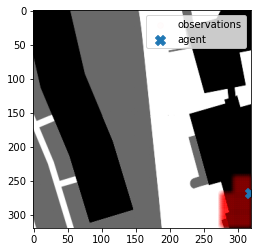

In [229]:
%time
RCenv.printState()

In [230]:
%%time
for i in range(20):
    RCenv.step(RCenv.action_space.sample()) #, prediction = 1)
    print(RCenv._agent_location)

[319 243]
[319 268]
[319 243]
[319 243]
[294 268]
[294 268]
[294 293]
[294 318]
[294 293]
[269 293]
[269 318]
[244 318]
[269 318]
[294 319]
[269 294]
[269 269]
[269 269]
[244 294]
[219 294]
[219 294]
CPU times: user 10.7 s, sys: 14.6 ms, total: 10.8 s
Wall time: 10.7 s


Steps: 1
Agent Position: [203  11] | Discount Factor: 0.99
Steps: 2
Agent Position: [228   0] | Discount Factor: 0.9801
Steps: 3
Agent Position: [253   0] | Discount Factor: 0.970299
Steps: 4
Agent Position: [253   0] | Discount Factor: 0.96059601
Steps: 5
Agent Position: [228  25] | Discount Factor: 0.9509900498999999
Steps: 6
Agent Position: [253   0] | Discount Factor: 0.941480149401
Steps: 7
Agent Position: [278   0] | Discount Factor: 0.9320653479069899
Steps: 8
Agent Position: [278   0] | Discount Factor: 0.9227446944279201
Episode terminated with reward: tensor([0.5000], device='cuda:0')


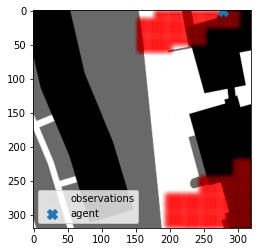

In [231]:
RCenv.reset()
terminated = False
while not terminated:
    observation, reward, terminated, interrupted, info = RCenv.step(RCenv.action_space.sample())# , prediction = 1)
    print(f"Steps: {RCenv.presentStep}")
    print(f"Agent Position: {RCenv._agent_location} | Discount Factor: {RCenv.gamma**RCenv.presentStep}")
    if terminated:
        print(f"Episode terminated with reward: {reward}")
        RCenv.printState()

# 3. Import Generator 

In [31]:
import sys
sys.path.append('../src/models/')
from Generator import OptGen

### 3.1 Params 

In [32]:
n_covs = random.randint(3,6)
drop_convs2d = random.uniform(0.4,0.6)
b_size = 64
nz = 100
ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # fills the weights? gamma param with normal distribution
        nn.init.constant_(m.bias.data, 0) # fills the bias with the constant 0

In [34]:
GNet = OptGen(ngpu, n_covs, drop_convs2d).to(device)
# no data parallelization needed, since there is one gpu
GNet.apply(weights_init)
print(GNet)

OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(10, 10), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(128, 64, kernel_size=(14, 14), stride=(2, 2), bias=False)
    (4): DropOut_2): Dropout2d(p=0.5184678388519982, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): Sigmoid()
  )
)


In [35]:
noise = torch.randn(b_size, nz, 1, 1, device=device)
fake = GNet(noise)
fake.shape

torch.Size([64, 3, 64, 64])

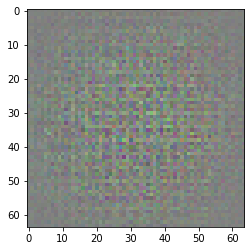

In [36]:
# plt.imshow(fake[0].permute(1,2,0).to(device))
plt.imshow(fake[0].cpu().detach().permute(1,2,0).numpy());

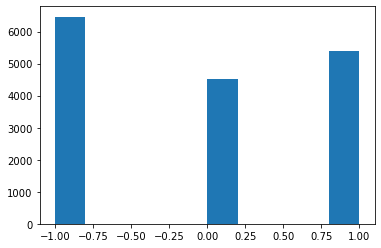

In [108]:
plt.hist(RCenv.reward_map.flatten());

# 4. DQN Network

In [232]:
class RealCityDQN(nn.Module):

    def __init__(self, n_actions, resolution, channels, obsRadius, memSlots):
        super(RealCityDQN, self).__init__()
        self.width = 0
        self.height = 0
        if isinstance(resolution, list):
            self.width = resolution[0]
            self.height = resolution[1]
        else:
            self.width = self.height = resolution
        self.cns = channels
        self.obsRadius = obsRadius
        self.memSlots = memSlots
        # image resolution + mask for observed pixels + memory of the last n observations
        self.inputSize = self.width * self.height * (self.cns + 1) + self.memSlots * (self.obsRadius * 2) ** 2 * self.cns 
        self.layer1 = nn.Linear(self.inputSize, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions + 1) # the last is the probability of the input to be true
        self.layer4 = nn.Sigmoid()

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [233]:
policyNet = RealCityDQN(n_actions=RCenv.action_space.n, resolution=[resolution, resolution], channels=channels, obsRadius=obsRadius, memSlots=memorySlots).to(device)
print(policyNet)

RealCityDQN(
  (layer1): Linear(in_features=447100, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
  (layer4): Sigmoid()
)


In [234]:
targetNet = RealCityDQN(n_actions=RCenv.action_space.n, resolution=[resolution, resolution], channels=channels,  obsRadius=obsRadius, memSlots=memorySlots).to(device)
targetNet.load_state_dict(policyNet.state_dict())

<All keys matched successfully>

# 5. Train Model

In [273]:
optimizer = optim.AdamW(policyNet.parameters(), lr=LR, amsgrad=True)
steps_done = 0
episode_durations = []

criterionBCE = nn.BCELoss()

optimisationOff = True

# implemented directly in the function
## def select_action(state):
##     global steps_done
##     sample = random.random()
##     eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
##     steps_done += 1
##     if sample > eps_threshold:
##         with torch.no_grad():
##             # t.max(1) will return the largest column value of each row.
##             # second column on max result is index of where max element was
##             # found, so we pick action with the larger expected reward.
##             return policyNet(state)[:RCenv.action_space.n].max(0)[1].view(1,1)
##     else:
##         return torch.tensor([[RCenv.action_space.sample()]], device=device, dtype=torch.long)

In [274]:
def optimize_model():
    
    global optimisationOff
    
    if len(RCenv.memory.transitions) < BATCH_SIZE:
        return
    else:
        if optimisationOff:
            print(f"enough transitions to start optimisation: {len(RCenv.memory.transitions)} > { BATCH_SIZE}")
            optimisationOff = False
    transitions = RCenv.memory.getTransitionSample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    prediction_batch = torch.cat(batch.prediction)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policyNet
    # state_action_values = policyNet(state_batch).gather(1, action_batch)
    state_action_values = policyNet(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" targetNet; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = targetNet(non_final_next_states)[:, :RCenv.action_space.n].max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Get the predictions for the non ended states
    predictions_non_final = prediction_batch[non_final_mask]
    label_batch = torch.full((predictions_non_final.size()[0],), label, dtype=torch.float, device=device).reshape(predictions_non_final.size()[0], 1)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss() # also Smooth l1 Loss, with default params: reduction='mean', beta=1.0
    errorBCE = criterionBCE(predictions_non_final, label_batch)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) + errorBCE # BLEND WITH GANS LOSS

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policyNet.parameters(), 100) # clips the gradients to a max of 100 -> is this useful here?
    optimizer.step()

In [275]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50 # 50

analyticsProb = [] # probabilities
analyticsRewards = [] # rewards

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    observation, info = RCenv.reset()
    # state = torch.cat((torch.tensor([RCenv.prediction]), torch.tensor(RCenv._get_obs()['agent']), RCenv._get_obs()['observation'])).to(device)
    state = RCenv.getState()
    for t in count():
        # Action selection, first exploration, then exploitation
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                res = policyNet(state)
                RCenv.prediction = res[0][-1].item()
                action = res[0][:RCenv.action_space.n].max(0)[1].view(1,1)
        else:
            action = torch.tensor([[RCenv.action_space.sample()]], device=device, dtype=torch.long)
        
        # action = select_action(state) # happens in the point above, because the self.prediction need also to be updated
        observation, reward, terminated, truncated, info = RCenv.step(action.item())
        # reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        # if terminated: # -> already done in RCenv class
        #     next_state = None 
        #  else:
        #      next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # 
        #  # Store the transition in memory
        #  memory.push(state, action, next_state, reward) -> already in RCenv class, by each step
        
        # Move to the next state
        state = RCenv.memory.transitions[-1].next_state
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        targetNet_state_dict = targetNet.state_dict()
        policyNet_state_dict = policyNet.state_dict()
        for key in policyNet_state_dict:
            targetNet_state_dict[key] = policyNet_state_dict[key]*TAU + targetNet_state_dict[key]*(1-TAU) # soft update rule, only tau part update
        targetNet.load_state_dict(targetNet_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            analyticsRewards.append(reward.item())
            analyticsProb.append(RCenv.prediction)
            if i_episode % 50 == 0:
                print(f"episode number {i_episode}, step {t}, probability: {RCenv.prediction}, reward: {reward.item()}, memory {len(RCenv.memory.transitions)}")
            # plot_durations()
            break

/opt/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


enough transitions to start optimisation: 375 > 128
episode number 0, step 2, probability: 0.5, reward: 0.5, memory 377
episode number 50, step 4, probability: 0.5, reward: 0.5, memory 1006
episode number 100, step 61, probability: 0.5, reward: 0.5, memory 2422


OutOfMemoryError: CUDA out of memory. Tried to allocate 220.00 MiB (GPU 0; 14.61 GiB total capacity; 13.47 GiB already allocated; 31.56 MiB free; 13.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.plot(analyticsProb);

## 2.1 PPO with Stable Baseline
not working :-(

In [158]:
budget_pendulum = 4000

In [32]:
ppo_model = PPO("MultiInputPolicy", RCenv, verbose=0).learn(budget_pendulum)

In [33]:
obs = RCenv.reset()

In [34]:
#why not QLearning?! Q Learning is not worse than PPO in many cases -> Double Deep Q Networks!!!!!!! 

my 

In [ ]:
ppo_model.predict(obs)

Python 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)


Observation Space.Space.item: odict_items([('agent', Box(0, 127, (2,), int64)), ('target', Box(0, 127, (2,), int64))])
In :  obs_as_tensor(observation, self.device)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In :  observation


array([{'agent': array([114,   2]), 'target': array([55, 23])},
       {'distance': 80.0}], dtype=object)

In :  list(observation)


[{'agent': array([114,   2]), 'target': array([55, 23])}, {'distance': 80.0}]

In :  key, items = observation.keys(), observation.values()


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In :  type(observation)


numpy.ndarray

In :  obs_as_tensor(observation, self.device)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In :  observation[0].values()


dict_values([array([114,   2]), array([55, 23])])

In :  array(observation[0].values())


NameError: name 'array' is not defined

In :  np.array(observation[0].values())


array(dict_values([array([114,   2]), array([55, 23])]), dtype=object)

In :  type(observation[0].values())


dict_values

In :  list(observation[0].values())


[array([114,   2]), array([55, 23])]

In :  t = list(observation[0].values())
In :  t.reshape((-1,) + self.observation_space[key].shape)


AttributeError: 'list' object has no attribute 'reshape'

In :  t = np.array(observation[0].values())
In :  t.reshape((-1,) + self.observation_space[key].shape)


NameError: name 'key' is not defined

In :  key


NameError: name 'key' is not defined

In :  observation_space


NameError: name 'observation_space' is not defined

In :  self.observation_space.shape
In :  self.observation_space.shape()


TypeError: 'NoneType' object is not callable

In :  self.observation_space


Dict('agent': Box(0, 127, (2,), int64), 'target': Box(0, 127, (2,), int64))

In [419]:
RCenv.step(RCenv.action_space.sample())

({'agent': array([113,   1]), 'target': array([55, 23])},
 -18.94427190999916,
 False,
 False,
 {'distance': 80.0})

In [423]:
RCenv.action_space.sample()

2

In [74]:
from stable_baselines3.common.env_checker import check_env

In [75]:
check_env(RCenv)

In [76]:
# env = YourEnv()
obs = RCenv.reset()
n_steps = 10
for _ in range(n_steps):
    # Random action
    action = RCenv.action_space.sample()
    obs, reward, done, truncated, info = RCenv.step(action)
    if done:
        print("DONE")
        obs = env.reset()

In [440]:
RCenv._get_obs()

{'agent': array([95, 81]), 'target': array([49, 57])}

In [441]:
obs = RCenv.reset()
# observation, Genv.step(Genv.action_space.sample())
# Genv.action_space.sample()

In [446]:
obs

({'agent': array([ 9, 77]), 'target': array([50, 28])}, {'distance': 90.0})

In [458]:
import gym
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box
import numpy as np
import random
import pygame
import stable_baselines3
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

from PIL import Image
import torch
import torchvision.transforms.functional as TF

# listing img files in directory data
from os import listdir
from os.path import isfile, join

import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [448]:
from stable_baselines3.common.env_util import make_vec_env

In [452]:
env = make_vec_env([RealCity(reward_map=ScoreSample)])

In [454]:
model = PPO("MultiInputPolicy", RCenv, verbose=1)
model.learn(total_timesteps=5000) # PPO("MultiInputPolicy", RCenv, verbose=0).learn(budget_pendulum)
model.save("RC_PPOModel")

del model # remove to demonstrate saving and loading

model = PPO.load("RC_PPOModel")

obs = RCenv.reset()
while True:
    action, _states = model.predict(obs)
    status, rewards, dones, info = env.step(action)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 725  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 536         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014274165 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -0.00149    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.01e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00952    |
|    value_loss        

In [ ]:
model.predict(obs)

Python 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)


Observation Space.Space.item: odict_items([('agent', Box(0, 127, (2,), int64)), ('target', Box(0, 127, (2,), int64))])
In :  dir()


['Dict',
 'GymEnv',
 'Iterable',
 'List',
 'Logger',
 'Optional',
 'Schedule',
 'SummaryWriter',
 'TensorDict',
 'TrainFreq',
 'TrainFrequencyUnit',
 'Tuple',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_non_vectorized',
 'check_for_correct_spaces',
 'check_shape_equal',
 'code',
 'compat_gym_seed',
 'configure',
 'configure_logger',
 'constant_fn',
 'deque',
 'explained_variance',
 'get_device',
 'get_latest_run_id',
 'get_linear_fn',
 'get_parameters_by_name',
 'get_schedule_fn',
 'get_system_info',
 'glob',
 'gym',
 'is_vectorized_box_observation',
 'is_vectorized_dict_observation',
 'is_vectorized_discrete_observation',
 'is_vectorized_multibinary_observation',
 'is_vectorized_multidiscrete_observation',
 'is_vectorized_observation',
 'key',
 'np',
 'obs_as_tensor',
 'observation',
 'observation_space',
 'os',
 'platform',
 'polyak_update',
 'random',
 're',
 'safe_mean',
 'sb3',
 'set_random_seed'

In :  observation


array([{'agent': array([111,  12]), 'target': array([ 8, 46])},
       {'distance': 137.0}], dtype=object)

In :  observation[0]


{'agent': array([111,  12]), 'target': array([ 8, 46])}

In :  key


'agent'

In :  observation[0][key]


array([111,  12])

In :  subspace


Box(0, 127, (2,), int64)

In :  subspace.shape


(2,)

In :  observation[0][key].shape != subspace.shape


False

In :  for key, subspace in observation_space.spaces.items():
...:      if observation[0][key].shape[1:] != subspace.shape:
...:          print(f"this key -> {key} is not vectorized")
...:  
this key -> agent is not vectorized
this key -> target is not vectorized
In :  observation[0][key].shape[1:]


()

In :  observation[0]['agent'].shape[1:]


()

In :  observation[0]['target'].shape[1:]


()

In :  observation[0]['agent'].shape


(2,)

In :  subspace.shape


(2,)

In :  observation_space.spaces.items()


odict_items([('agent', Box(0, 127, (2,), int64)), ('target', Box(0, 127, (2,), int64))])

In :  observation


array([{'agent': array([111,  12]), 'target': array([ 8, 46])},
       {'distance': 137.0}], dtype=object)

In :  observation_space


Dict('agent': Box(0, 127, (2,), int64), 'target': Box(0, 127, (2,), int64))

In :  quit()


NameError: name 'quit' is not defined

In :  exit()


NameError: name 'exit' is not defined


KeyboardInterrupt


In :  
In :  
In :  exit()


NameError: name 'exit' is not defined

In :  3+6


9


KeyboardInterrupt

KeyboardInterrupt


In [445]:
obs.observation_space

AttributeError: 'tuple' object has no attribute 'observation_space'

## Appendix A: Example of DQN with Pytorch
Deep Q Learning, based on: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [185]:
plt.ion() # acitvates interactive plot

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [186]:
env = gym.make("CartPole-v1")

In [187]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [188]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # a deque (deck) is a list type container with fast pop/append on either ends

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(population=self.memory, k=batch_size) # return n=batch_size random samples from a list, string, set or tuple 

    def __len__(self):
        return len(self.memory)

In [189]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [202]:
state, info = env.reset() # state, info = env.reset()
print(state)
print(info)

[ 0.04673086 -0.02089705 -0.04949452 -0.01308087]
{}


In [203]:
state = np.array(list(state.values())).flatten()
state

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [191]:
# status must be consolidated in a single np.array with 4 elements agent x, agent y, target x, target y

In [194]:
s, i = env.reset()
print(f"status length: {len(s)}, status: {s}")

status length: 4, status: [ 0.00021598  0.01724805  0.03431011 -0.01503548]


In [227]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = RCenv.action_space.n # n_actions = env.action_space.n
# Get the number of state observations
state, info = RCenv.reset() # state, info = env.reset()
state = np.array(list(state.values())).flatten() # agent x, agent y, target x, target y in a flat array
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        return torch.tensor([[RCenv.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

/tmp/ipykernel_35063/3078912199.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  state = np.array(list(state.values())).flatten() # agent x, agent y, target x, target y in a flat array


In [227]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = RCenv.memory.getTransitionSample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policyNet
    state_action_values = policyNet(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states)[:RCenv.action_space.n].max(0)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policyNet.parameters(), 100)
    optimizer.step()

In [229]:
if torch.cuda.is_available():
    num_episodes = 60
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = RCenv.reset() # state, info = env.reset()
    # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = torch.tensor(state['agent'], dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = RCenv.step(action.item()) # observation, reward, terminated, truncated, _ = env.step(action.item()) 
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.tensor(observation['agent'], dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policyNet_state_dict = policyNet.state_dict()
        for key in policyNet_state_dict:
            target_net_state_dict[key] = policyNet_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: 

In [138]:
env.step(env.action_space.sample())

(array([-0.00808663,  0.19616404, -0.01706432, -0.2940259 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [139]:
RCenv.step(action.item())

({'agent': array([111,  10]), 'target': array([ 8, 46])},
 -1.7898261225515952,
 False,
 False,
 {'distance': 139.0})

# Appendix B: Shower Example
based on the video: https://www.youtube.com/watch?v=bD6V3rcr_54

In [372]:
class ShowerEnv(Env):
    
    def __init__(self):
        # actions
        self.action_space = Discrete(3)
        # state
        self.state = 38 + random.randint(-3,3)
        # observation
        self.observation_space = Box(low = np.array([0]), high = np.array([100]))
        # episodes
        self.episodes_length = 60
        
    def step(self, action):
        reward = 0
        self.state += action - 1
        self.episodes_length -= 1
        if self.state >=37 and self.state <= 39:
            reward += 1
        else:
            reward -= 1
        # check if the time is up 
        if self.episodes_length <= 0:
            done = True
        else:
            done = False
        # Apply temperature noise
        self.state += random.randint(-1,1)
        
        # placeholder for info
        info = spaces.Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
        
        return self.state, reward, done, info
        
    def render(self):
        # implement visualization
        pass
    def reset(self):
        # reset
        self.state = 38 + random.randint(-3,3)
        self.episodes_length = 60
        return self.state

In [373]:
ShowerEnv = ShowerEnv()

/opt/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [377]:
ShowerEnv.observation_space.sample()

array([74.26477], dtype=float32)

In [379]:
ShowerEnv.step(ShowerEnv.action_space.sample())

(40, -1, False, Box(-1.0, 2.0, (3, 4), float32))

In [381]:
episodes = 10
for episode in range(episodes):
    state = ShowerEnv.reset()
    done = False
    score = 0
    
    while not done:
        action = ShowerEnv.action_space.sample()
        n_state, reward, done, info = ShowerEnv.step(action)
        score += reward
    print('Episode: {} | State: {} | Action: {} | Score: {}'.format(episode, n_state, action, score))

Episode: 0 | State: 41 | Action: 2 | Score: -46
Episode: 1 | State: 32 | Action: 0 | Score: -6
Episode: 2 | State: 45 | Action: 1 | Score: -48
Episode: 3 | State: 37 | Action: 0 | Score: 12
Episode: 4 | State: 35 | Action: 0 | Score: -14
Episode: 5 | State: 35 | Action: 2 | Score: -44
Episode: 6 | State: 33 | Action: 0 | Score: -46
Episode: 7 | State: 50 | Action: 1 | Score: -48
Episode: 8 | State: 30 | Action: 0 | Score: -18
Episode: 9 | State: 36 | Action: 1 | Score: -16


## RL on "shower environment"

In [382]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

In [76]:
# pip install stable_baselines3

In [383]:
# 4000 training timesteps
budget_pendulum = 4000

In [385]:
ppo_model = PPO("MlpPolicy", ShowerEnv, verbose=0).learn(budget_pendulum)

TypeError: cannot unpack non-iterable int object

In [ ]:
ppo_model.learn(total_timesteps=1000)

In [ ]:
obs = env.reset()

In [ ]:
while True:
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = env.step(action)

In [96]:
env.step(action)

(37, 1, False, {})

In [386]:
import gym
env = gym.make("LunarLander-v2", render_mode="human")
env.action_space.seed(42)

observation, info = env.reset(seed=42)

for _ in range(1000):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())

    if terminated or truncated:
        observation, info = env.reset()

env.close()

DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`